In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
import logistic_regression as lr
import naive_bayes as nb

In [25]:
def _compute_baselines(train):
    '''
        Compute following baselines and add to training file
        (1) RIVER
        (2) shared LR
        (3) tissue-spec LR
    '''
    shared_expr = _compute_shared_expression_labels(expression)
    if 'shared_label' in train.columns:
        train = train.drop('shared_label', axis=1)
    trains = []
    tissues = []
    # for each tissue group
    for tissue in tissue_groups:
        x = train[train["tissue"] == tissue]
        x = pd.concat([x, shared_expr["shared_label"]], axis=1).dropna()
        x["posterior_genome_only"] = _compute_tissue_specific_genome_only_posteriors(x, tissue, genomic_features)
        x["posterior_RIVER"] =  _compute_RIVER_posteriors(x, beta_river, phi_river, genomic_features)
        x["posterior_genome_only_shared"] =  _compute_shared_tissue_genome_only_posteriors(x, genomic_features)
        trains.append(x)
    train_all = pd.DataFrame()
    for i in range(len(trains)):
        train_all = train_all.append(trains[i])
    return train_all

def _compute_RIVER_posteriors(x, beta, phi, genomic_features):
    # log P(Z = 1 | G)
    log_prob_z_1_given_g = lr.log_prob(x[genomic_features].values, beta)

    # log P(Z = 0 | G)
    log_prob_z_0_given_g = np.log(1.0 - np.exp(log_prob_z_1_given_g))

    # log P(E | Z = 1)
    log_prob_e_given_z_1 = nb.log_prob(x['shared_label'].values, 1, phi)
    # log P(E | Z = 0)
    log_prob_e_given_z_0 = nb.log_prob(x['shared_label'].values, 0, phi)
    log_q = log_prob_e_given_z_1 + log_prob_z_1_given_g -  np.log(np.exp(log_prob_e_given_z_0) * np.exp(log_prob_z_0_given_g) + np.exp(log_prob_e_given_z_1) * np.exp(log_prob_z_1_given_g))

    return np.exp(log_q) 
    
def _compute_shared_expression_labels(expression):
    shared_expr = expression[tissue_groups_shared['shared']].dropna(thresh = NUM_OBSERVED)
    shared_expr["median"] = np.abs(shared_expr).median(axis=1)
    shared_expr["shared_label"] = sklearn.preprocessing.binarize(np.abs(shared_expr["median"]).reshape(-1,1), threshold = OUTLIER_THRESH)
    return shared_expr

def _compute_shared_tissue_genome_only_posteriors(train, genomic_features):
    # train
    beta = lr.sgd(train[genomic_features].values, train["shared_label"].values, 
                  np.zeros(len(genomic_features)), np.zeros(len(genomic_features)), 0.01)
    # predict on test data
    return np.exp(lr.log_prob(train[genomic_features].values, beta))

def _compute_tissue_specific_genome_only_posteriors(x, tissue, genomic_features):
    beta = lr.sgd(x[genomic_features].values, x["expr_label"].values, 
                  np.zeros(len(genomic_features)), np.zeros(len(genomic_features)), 0.01)
    # predict on test data
    return np.exp(lr.log_prob(x[genomic_features].values, beta))

In [184]:
beta_river.shape

(119,)

In [189]:
train.columns[0:-5]

Index(['intercept', 'max_CpG_10kb', 'max_PHRED_10kb', 'max_verPhCons_10kb',
       'max_cHmmTssA_10kb', 'max_mamPhCons_10kb', 'max_verPhyloP_10kb',
       'max_GC_10kb', 'max_EncOCpolIIPVal_10kb', 'max_TFBS_10kb',
       ...
       'E107_general_promoter', 'E107_general_enhancer',
       'E108_general_promoter', 'E108_general_enhancer',
       'E110_general_promoter', 'E110_general_enhancer',
       'E111_general_promoter', 'E111_general_enhancer',
       'E113_general_promoter', 'E113_general_enhancer'],
      dtype='object', length=119)

In [19]:
train.columns[0:-5]

Index(['intercept', 'max_CpG_10kb', 'max_PHRED_10kb', 'max_verPhCons_10kb',
       'max_cHmmTssA_10kb', 'max_mamPhCons_10kb', 'max_verPhyloP_10kb',
       'max_GC_10kb', 'max_EncOCpolIIPVal_10kb', 'max_TFBS_10kb',
       ...
       'E107_general_promoter', 'E107_general_enhancer',
       'E108_general_promoter', 'E108_general_enhancer',
       'E110_general_promoter', 'E110_general_enhancer',
       'E111_general_promoter', 'E111_general_enhancer',
       'E113_general_promoter', 'E113_general_enhancer'],
      dtype='object', length=119)

In [ ]:
'../src/11.17.16.gtex_data_2.5_threshold/

In [29]:
# read in training data
OUTLIER_THRESH = 2.25
NUM_OBSERVED = 5
#train = pd.read_csv("../src/11.17.16.gtex_data_1.0_threshold/train.csv", index_col = (0,1))
#train = pd.read_csv("../multi_task_model_optimal_1.5_threshold/train.csv", index_col=(0,1))
train = pd.read_csv("../src/11.19.16.gtexrun_2.25_thresh_multitask/train.csv", index_col=(0,1))

num_tissues = len(list(set(train["tissue"])))
beta_river = pd.read_table('../src/11.19.run_2.25_threshold_5_observed/beta_children.txt', header=None, delimiter=' ').values.reshape(-1)

#beta_river = pd.read_table('../input/beta_RIVER.v6.txt', header=None, delimiter=' ').values.reshape(-1)
phi_river = np.loadtxt('../src/11.19.run_2.25_threshold_5_observed/phi.txt')
#phi_river = np.loadtxt('../src/11.19.run_1.5_threshold_5_observed/phi.txt')
expression = pd.read_csv("../input/expression.short.csv", index_col=(0,1))
genomic_features = train.columns[0:-9]

train = _compute_baselines(train)

In [30]:
#train = pd.read_csv("../multi_task_model_optimal_1.5_threshold/train.csv")
train["gene_id"] = train.index.get_level_values("gene_id")
train["subject_id"] = train.index.get_level_values("subject_id")
ase = pd.read_csv("../input/ase_train.csv", index_col=(0,1))

train["gene_id"] = [g.split(".")[0] for g in train["gene_id"]]

train.index = [train["subject_id"], train["gene_id"]]
trains = []
for tissue in list(tissue_groups.keys()):
    if tissue == 'brain':
        x = pd.concat([train[train["tissue"] == tissue][["posterior", "posterior_RIVER", "posterior_genome_only", "posterior_genome_only_shared", "expr_label"]], ase[tissue_groups[tissue]].dropna(thresh = 3).median(axis=1)], axis=1).dropna()
        #x = pd.concat([train[train["tissue"] == tissue][["posterior"]], ase[tissue_groups[tissue]].dropna(thresh = 3).median(axis=1)], axis=1).dropna()
    elif tissue == 'group1':
        x = pd.concat([train[train["tissue"] == tissue][["posterior", "posterior_RIVER", "posterior_genome_only", "posterior_genome_only_shared", "expr_label"]], ase[tissue_groups[tissue]].dropna(thresh = 4).median(axis=1)], axis=1).dropna()
    elif len(tissue_groups[tissue]) == 1:
        x = pd.concat([train[train["tissue"] == tissue][["posterior", "posterior_RIVER", "posterior_genome_only", "posterior_genome_only_shared", "expr_label"]], ase[tissue_groups[tissue]].dropna(thresh = 1).median(axis=1)], axis=1).dropna()
    else:
        x = pd.concat([train[train["tissue"] == tissue][["posterior", "posterior_RIVER", "posterior_genome_only", "posterior_genome_only_shared", "expr_label"]], ase[tissue_groups[tissue]].dropna(thresh = 2).median(axis=1)], axis=1).dropna()
    
    x.columns = ['Multi-task','RIVER', 'Genome only tissue-specific', 'Genome only tissue-shared', 'expr_label', "median_ase"]
    trains.append(x)
    print(tissue)

for train in trains:
    thresh = train["median_ase"].quantile(.9)
    rate = len(train[train["median_ase"] > thresh]) / len(train)
    train["average"] = rate

brain
muscle
group1
epithelial
digestive


In [42]:
def processTissueGroups(tissue_groups_path):
    tissue_groups = {}
    f = open(tissue_groups_path)
    for l in f:
        w = l.strip().split(',')
        group = w[0]
        tissue_groups[group] = []
        for tissue in w[1:]: tissue_groups[group].append(tissue)
    return tissue_groups

# read in tissue groups
tissue_groups = processTissueGroups("../tissue_groups/t3.txt")
tissue_groups_shared = processTissueGroups("../tissue_groups/shared.txt")


In [40]:
tissue_groups

{'brain': ['Brain_Caudate_basal_ganglia',
  'Brain_Nucleus_accumbens_basal_ganglia',
  'Brain_Putamen_basal_ganglia',
  'Brain_Anterior_cingulate_cortex_BA24',
  'Brain_Cortex',
  'Brain_Frontal_Cortex_BA9'],
 'digestive': ['Stomach', 'Colon_Transverse', 'Lung', 'Thyroid', 'Prostate'],
 'epithelial': ['Skin_Not_Sun_Exposed_Suprapubic',
  'Skin_Sun_Exposed_Lower_leg',
  'Esophagus_Mucosa',
  'Vagina'],
 'group1': ['Artery_Coronary',
  'Artery_Aorta',
  'Artery_Tibial',
  'Esophagus_Muscularis',
  'Esophagus_Gastroesophageal_Junction',
  'Colon_Sigmoid',
  'Adipose_Subcutaneous',
  'Adipose_Visceral_Omentum',
  'Breast_Mammary_Tissue'],
 'muscle': ['Muscle_Skeletal',
  'Heart_Atrial_Appendage',
  'Heart_Left_Ventricle']}

In [43]:
tissue_groups

{'brain': ['Brain_Caudate_basal_ganglia',
  'Brain_Nucleus_accumbens_basal_ganglia',
  'Brain_Putamen_basal_ganglia',
  'Brain_Anterior_cingulate_cortex_BA24',
  'Brain_Cortex',
  'Brain_Frontal_Cortex_BA9'],
 'digestive': ['Stomach', 'Colon_Transverse', 'Lung', 'Thyroid', 'Prostate'],
 'epithelial': ['Skin_Not_Sun_Exposed_Suprapubic',
  'Skin_Sun_Exposed_Lower_leg',
  'Esophagus_Mucosa',
  'Vagina'],
 'group1': ['Artery_Coronary',
  'Artery_Aorta',
  'Artery_Tibial',
  'Esophagus_Muscularis',
  'Esophagus_Gastroesophageal_Junction',
  'Colon_Sigmoid',
  'Adipose_Subcutaneous',
  'Adipose_Visceral_Omentum',
  'Breast_Mammary_Tissue'],
 'muscle': ['Muscle_Skeletal',
  'Heart_Atrial_Appendage',
  'Heart_Left_Ventricle']}

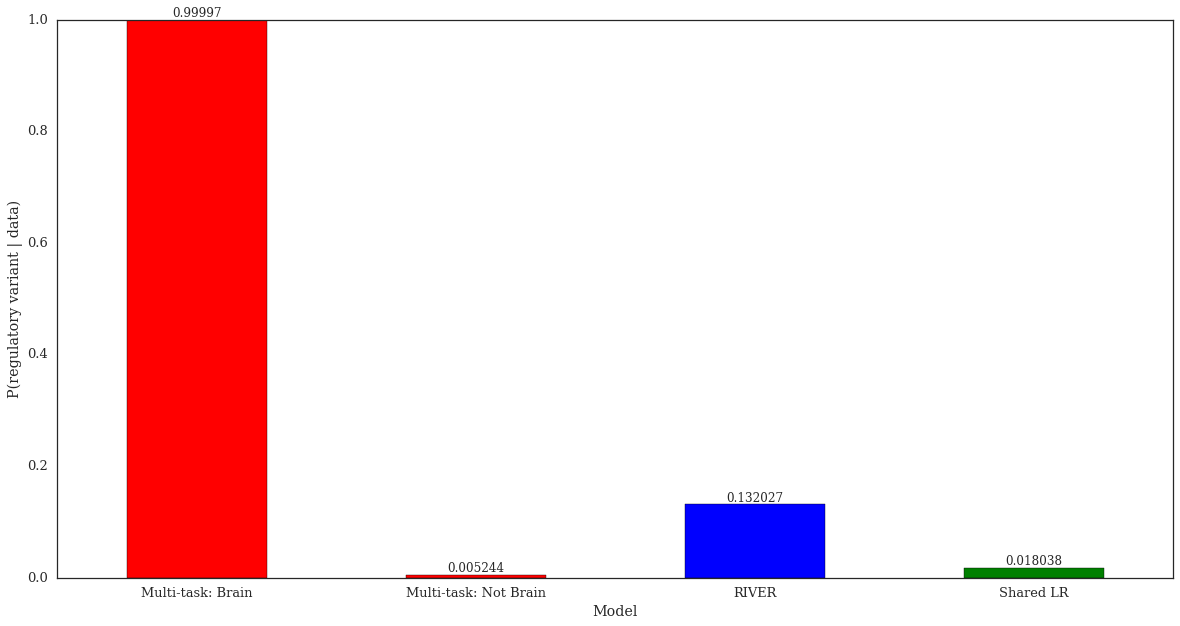

In [41]:
l = [0.999970, 0.005244, 0.132027, 0.018038]
x = pd.DataFrame(l)
x.columns = ['Prediction score']
x.index = ['Multi-task: Brain', 'Multi-task: Not Brain', 'RIVER', 'Shared LR']
plt.figure()
plt.style.use('seaborn-talk')
ax = x.plot(kind='bar', legend=None, figsize=(20,10),rot=0,color=['r', 'r', 'b', 'g'])
ax.set_xlabel("Model")
ax.set_ylabel("P(regulatory variant | data)")
rects = ax.patches
labels = x.values.reshape(-1)
for rect, label in zip(rects,labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()-0.25, height, label, ha='center', va='bottom')

In [491]:
expression = pd.read_csv("../../../../../../data/train/train_all_tissues.csv")
#expression = pd.read_csv("../input/expression.short.csv")

In [538]:
expression_v6 = pd.read_csv("../input/expression.short.csv")
expression_v6["gene_id"] = [g.split(".")[0] for g in expression_v6["gene_id"].values]
expression_v6.index = [expression_v6["subject_id"], expression_v6["gene_id"]]
expression_v6 = expression_v6.drop(["subject_id", "gene_id"], axis=1)

In [215]:
#models = ['Multi-task','RIVER', 'Genome only tissue-specific', 'Genome only tissue-shared']#, 'average']
#models = ['posterior']

models = ['posterior','posterior_RIVER','posterior_genome_only', 'posterior_genome_only_shared']

In [53]:
results = pd.DataFrame()

In [6]:
x = pd.DataFrame()
for i in range(len(trains)):
    x = x.append(trains[i])

In [423]:
for i,train in enumerate(trains):
    print(len(train))

5786
2845
6806
8084
13142


In [434]:
len(x)

36663

In [119]:
for i,train in enumerate(trains):
    print(len(train))

13142
8084
6806
5786
2845


In [36]:
list(tissue_groups.keys())

['brain', 'muscle', 'group1', 'epithelial', 'digestive']

In [336]:
x.head()

Multi-task     RIVER  Genome only tissue-specific  \
subject_id gene_id                                                              
GTEX-N7MS  ENSG00000003402    0.000230  0.006237                     0.072187   
           ENSG00000004534    0.000192  0.004994                     0.049397   
           ENSG00000004660    0.000224  0.002992                     0.062486   
           ENSG00000005075    0.000142  0.003026                     0.047676   
           ENSG00000005882    0.000329  0.003805                     0.075642   

                            Genome only tissue-shared  expr_label  median_ase  \
subject_id gene_id                                                              
GTEX-N7MS  ENSG00000003402                   0.025668         0.0    0.068966   
           ENSG00000004534                   0.022199         0.0    0.039062   
           ENSG00000004660                   0.014856         0.0    0.028822   
           ENSG00000005075                   0.015412         0.0    0.038462   
           ENSG00000005882                   0.018722         0.0    0.043155   

                             average  
subject_id gene_id                    
GTEX-N7MS  ENSG00000003402  0.100176  
           ENSG00000004534  0.100176  
           ENSG00000004660  0.100176  
           ENSG00000005075  0.100176  
           ENSG00000005882  0.100176

In [7]:
x.columns = ['Multi-task','RIVER', 'Genome only tissue-specific', 'Genome only tissue-shared', 'expr_label', "median_ase", "average"]

In [339]:
x["median_ase"].quantile(0.9)

0.13636363636399998

In [8]:
xr = x[x["median_ase"] > 0.13636363636399998]
data = xr[['Multi-task','RIVER', 'Genome only tissue-specific', 'Genome only tissue-shared']]
data = data[data > 0.5]

In [351]:
models.columns = ['Multi-task','RIVER', 'Genome only tissue-specific', 'Genome only tissue-shared']

In [350]:
len(models["Multi-task"].dropna()), len(models["RIVER"].dropna()), len(models["Genome only tissue-specific"].dropna()), len(models["Genome only tissue-shared"].dropna()), 

(120, 98, 3, 2)

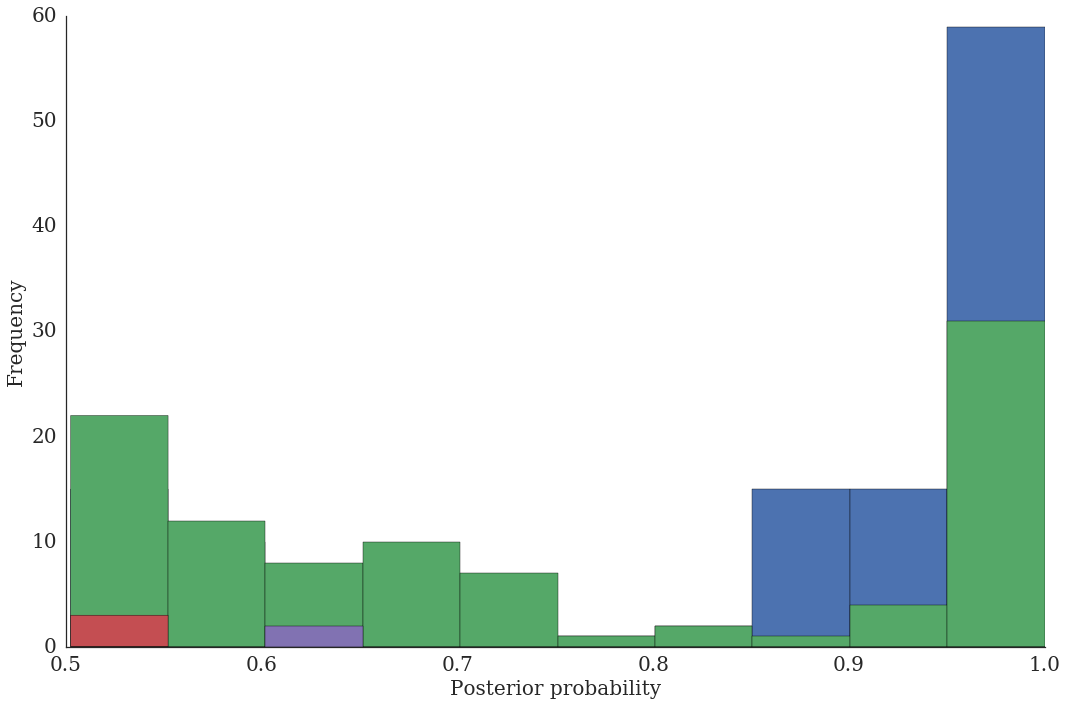

In [387]:
fig = plt.figure(1)
plt.style.use('seaborn-talk')
ax = data.plot(kind='hist',title=None,use_index=True, sort_columns=True, rot=360, figsize=(15,10),legend=None)
ax.set_xlabel("Posterior probability", fontsize=20)
ax.set_ylabel("Frequency", fontsize=20)
#ax.legend(loc = 'upper left', borderpad=2, labelspacing = 1, fontsize=15)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
#plt.savefig("../src/10.15.16.11groups.v7/"+tissue+"_ase.png")

sns.set_context("paper")
sns.set_palette("deep")
sns.set(font='serif')
sns.set_style("white", {"font.family": "serif", "font.serif": ["Times", "Palatino", "serif"]})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()    

In [33]:
models = ['Multi-task', 'RIVER', 'Genome only tissue-specific', 'Genome only tissue-shared', 'average']

In [31]:
x = pd.DataFrame()
for i in range(len(trains)):
    x = x.append(trains[i])

In [404]:
tissues = list(tissue_groups.keys())
tissues = ['Brain', 'Muscle', 'Artery/Fats', 'Epithelial', 'Digestive']

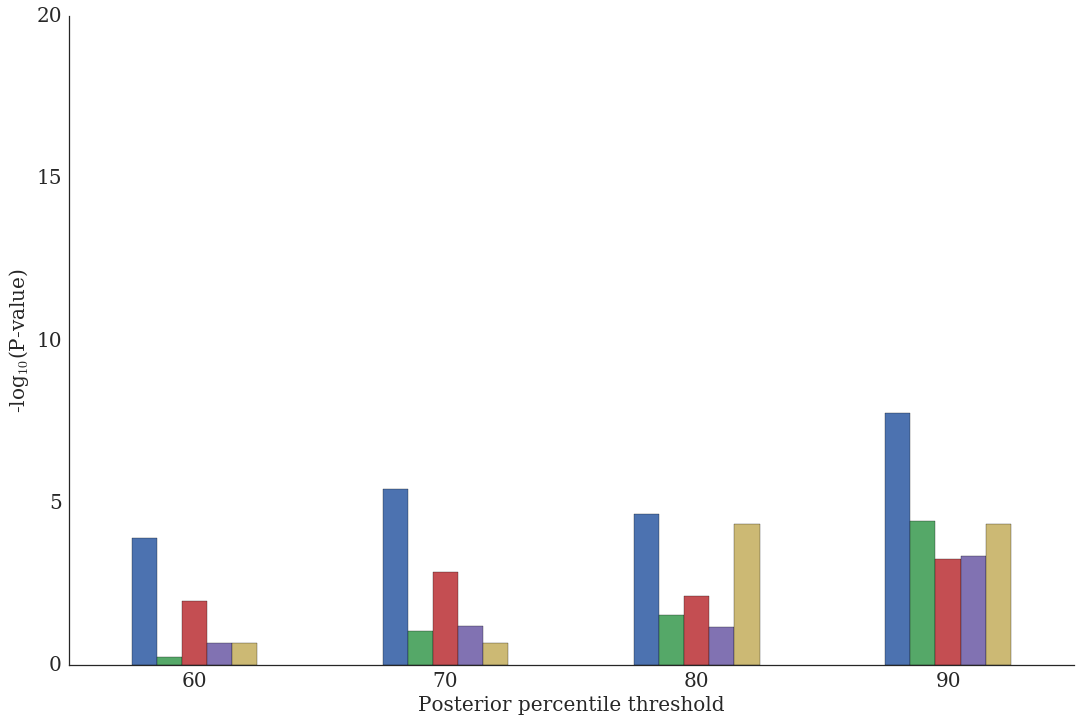

In [35]:
models = ['Multi-task', 'RIVER', 'Genome only tissue-specific', 'Genome only tissue-shared', 'average']
thresholds = [.6, .7, .8, .9]
%matplotlib inline
list(tissue_groups.keys())
for i,train in enumerate(trains):
    tissue = list(tissue_groups.keys())[i]
    #if i <= 20: continue
    results_list = []
    for thresh in thresholds:
        pvalues = []
        for model in models:
            shared_combined_mod = x
            shared_med_90_quant = shared_combined_mod['median_ase'].quantile(.90)
            shared_post_90_quant = shared_combined_mod[model].quantile(thresh)

            r = shared_combined_mod[shared_combined_mod['median_ase'] > shared_med_90_quant]
            
            top_left = r[r[model] > shared_post_90_quant].count()[-1]
            r = shared_combined_mod[shared_combined_mod['median_ase'] <= shared_med_90_quant]
            top_right = r[r[model] > shared_post_90_quant].count()[-1]
            r = shared_combined_mod[shared_combined_mod['median_ase'] > shared_med_90_quant]
            bottom_left = r[r[model] <= shared_post_90_quant].count()[-1]

            r = shared_combined_mod[shared_combined_mod['median_ase'] <= shared_med_90_quant]
            bottom_right = r[r[model] <= shared_post_90_quant].count()[-1]

            top = [top_left, top_right]
            bottom = [bottom_left, bottom_right]
            from scipy import stats
            oddsratio, pvalue = stats.fisher_exact([top, bottom])
            negative_log10_pvalue = -np.log10(pvalue)
            pvalues.extend([negative_log10_pvalue])
        results_list.append(pvalues)
    results = pd.DataFrame(results_list)
    #results.columns = list(train.columns[0:4])
    results.columns = models
    results.index = ["60", "70", "80", "90"]
    results.index.name

    fig = plt.figure(2)
    fig.set_size_inches(3, 3)
    #plt.tight_layout()
    #plt.style.use('seaborn-talk')
    sns.set_context("paper")
    sns.set_palette("deep")
    sns.set(font='serif')
    sns.set_style("white", {"font.family": "serif", "font.serif": ["Times", "Palatino", "serif"]})

    #sns.palplot(sns.color_palette("Set1", n_colors=8, desat=.5))

    ax = results.plot(kind='bar',use_index=True, sort_columns=True, rot=360, figsize=(15,10),legend=None)
    #ax.hlines(3.5, -0.5, 4.5, linestyles='--', linewidth=1)
    ax.set_xlabel("Posterior percentile threshold", fontsize=20)
    ax.set_ylabel("-log$_{10}$(P-value)", fontsize=20)
    ax.set_ylim(0,20)
    #ax.legend(loc = 'upper left', borderpad=2, labelspacing = 1, fontsize=15)
    plt.tight_layout()
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    #plt.figtext(0.5, 0.9, tissues[i], fontsize=20, ha='center')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.savefig("../src/10.15.16.11groups.v7/"+tissue+"_ase.png")
    break
    

In [274]:
results.T

,60,70,80,90
Multi-task,6.975843,10.381729,8.978184,26.219335
RIVER,2.599880,2.822055,6.068997,16.982153
Genome only tissue-specific,0.991310,2.793930,1.578103,1.627815
Genome only tissue-shared,0.449289,0.721568,0.499355,1.627815


In [281]:
results.index.name = 'models'
results.columns.name = 'thresholds'

In [282]:
sns.barplot(data = results.T, x = 'thresholds', y = 'pvalue', hue='models')

ValueError: Could not interpret input 'thresholds'

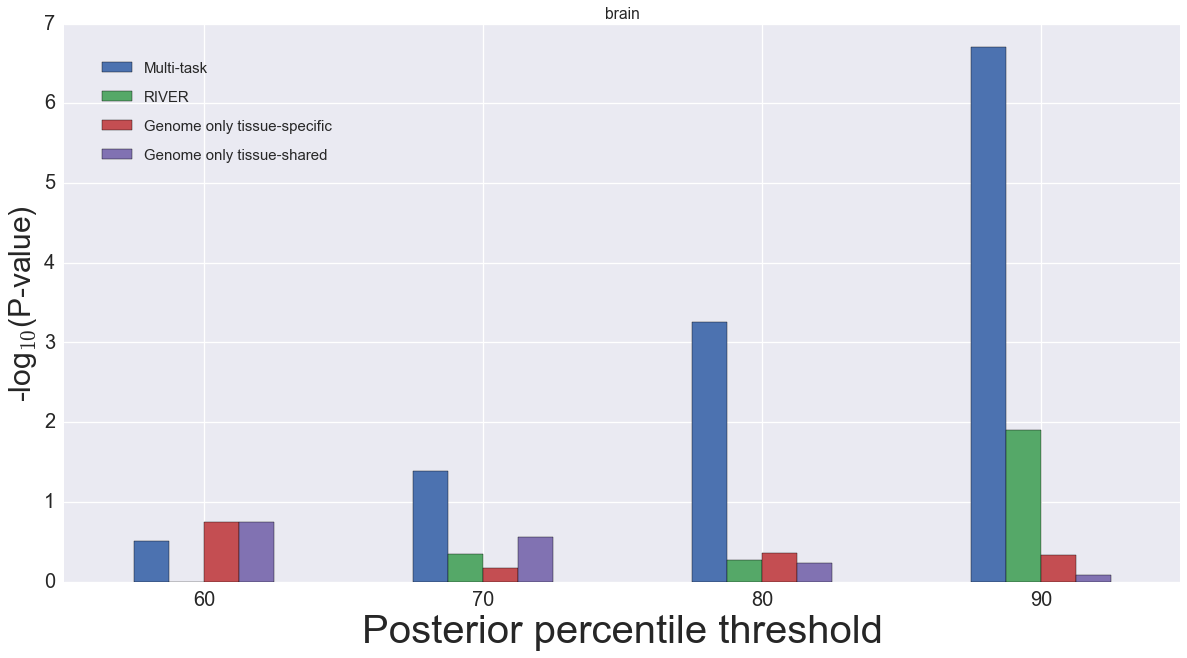

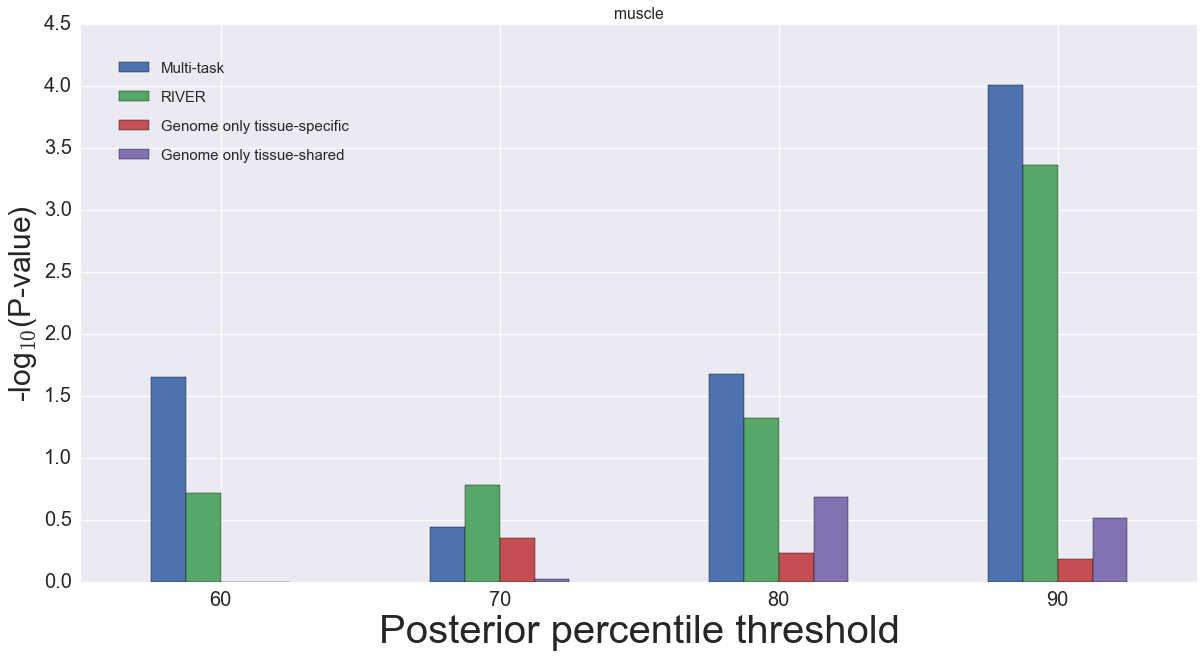

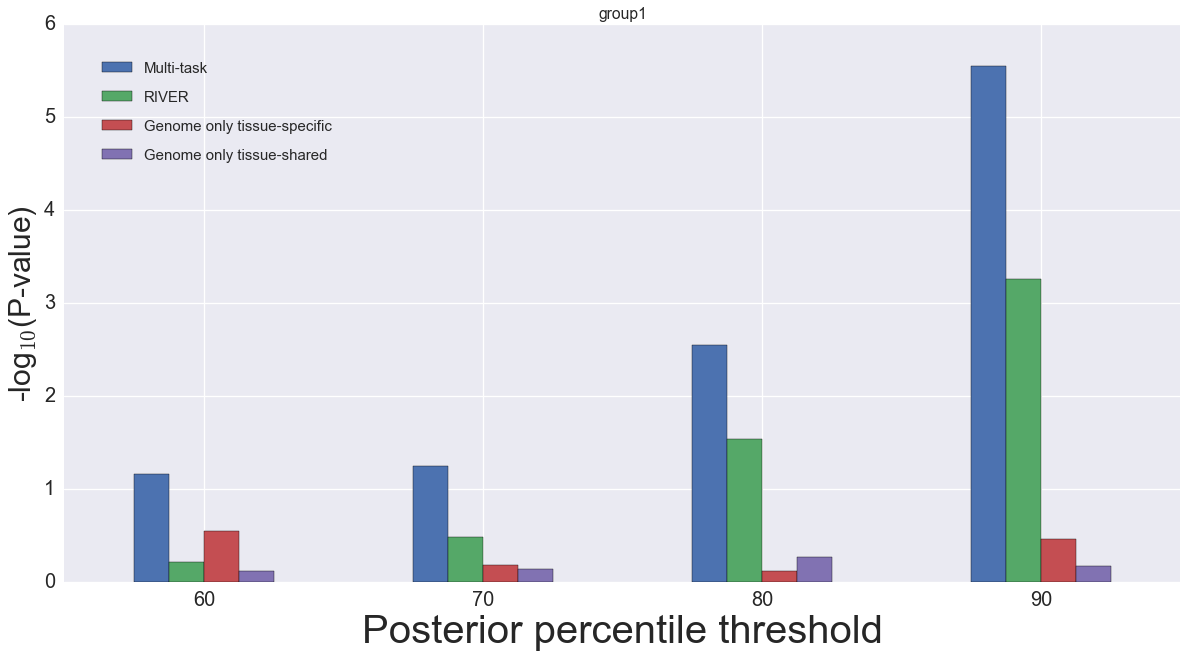

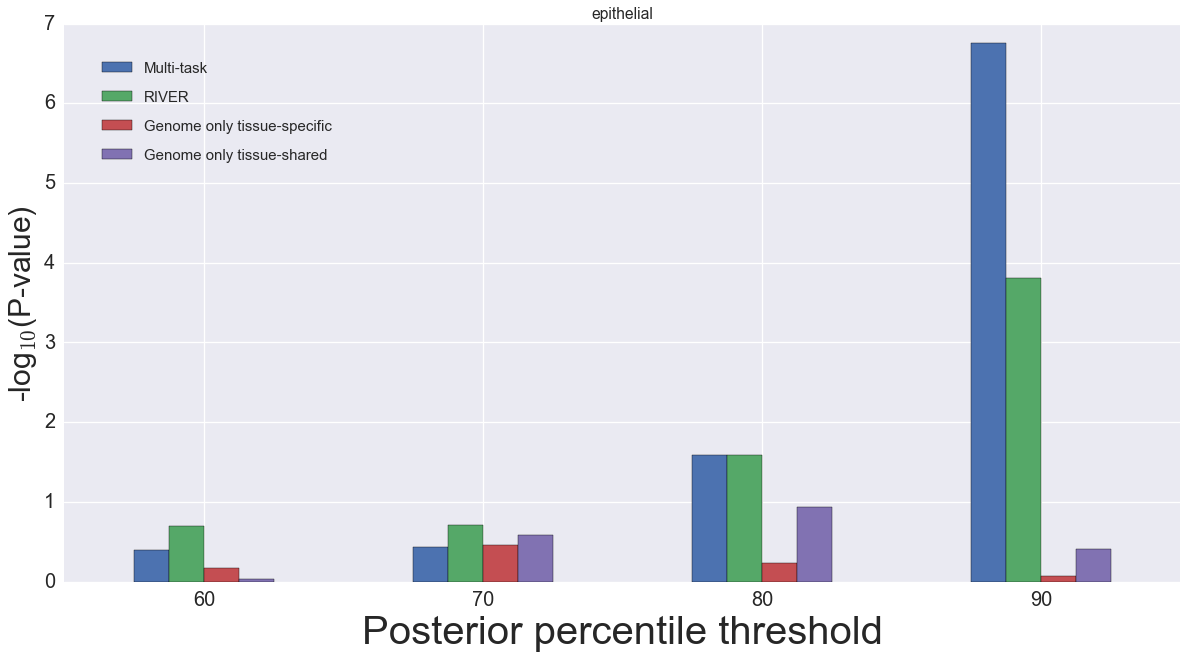

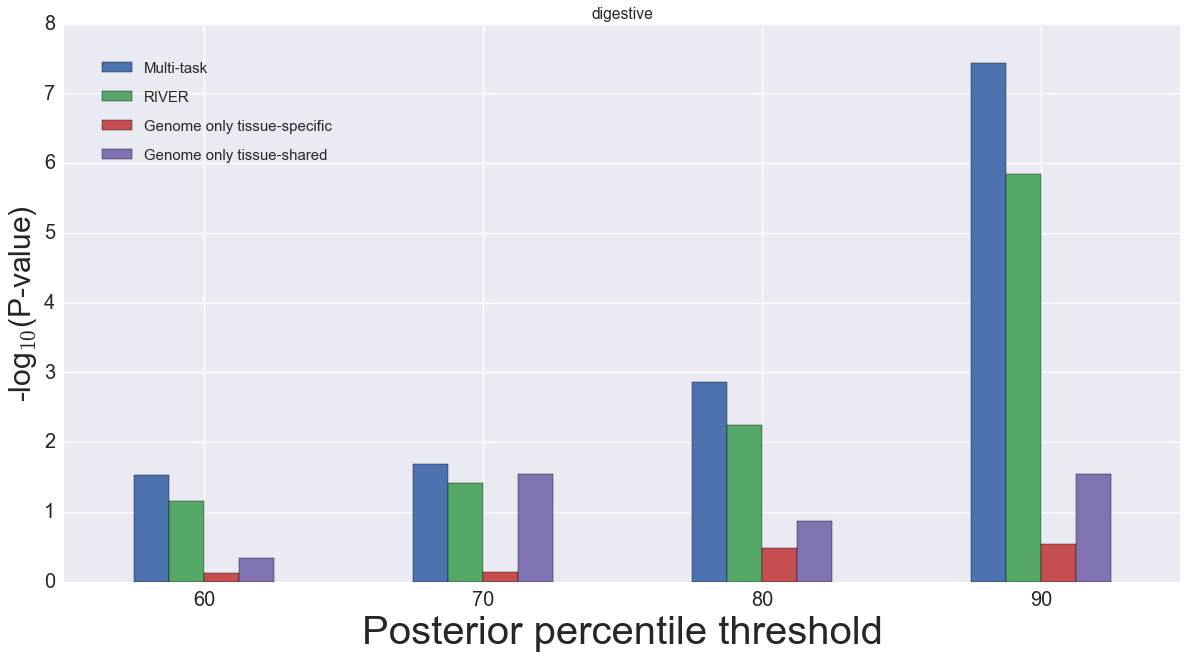

In [142]:
thresholds = [.6, .7, .8, .9]
%matplotlib inline
list(tissue_groups.keys())
for i,train in enumerate(trains):
    tissue = list(tissue_groups.keys())[i]
    #if i <= 20: continue
    results_list = []
    for thresh in thresholds:
        pvalues = []
        for model in models:
            shared_combined_mod = train
            shared_med_90_quant = shared_combined_mod['median_ase'].quantile(.9)
            shared_post_90_quant = shared_combined_mod[model].quantile(thresh)

            r = shared_combined_mod[shared_combined_mod['median_ase'] > shared_med_90_quant]
            
            top_left = r[r[model] > shared_post_90_quant].count()[-1]
            r = shared_combined_mod[shared_combined_mod['median_ase'] <= shared_med_90_quant]
            top_right = r[r[model] > shared_post_90_quant].count()[-1]
            r = shared_combined_mod[shared_combined_mod['median_ase'] > shared_med_90_quant]
            bottom_left = r[r[model] <= shared_post_90_quant].count()[-1]

            r = shared_combined_mod[shared_combined_mod['median_ase'] <= shared_med_90_quant]
            bottom_right = r[r[model] <= shared_post_90_quant].count()[-1]

            top = [top_left, top_right]
            bottom = [bottom_left, bottom_right]
            from scipy import stats
            oddsratio, pvalue = stats.fisher_exact([top, bottom])
            negative_log10_pvalue = -np.log10(pvalue)
            pvalues.extend([negative_log10_pvalue])
        results_list.append(pvalues)
    results = pd.DataFrame(results_list)
    results.columns = list(train.columns[0:4])
    results.index = ["60", "70", "80", "90"]
    results.index.name

    fig = plt.figure()
    plt.style.use('seaborn-talk')
    ax = results.plot(kind='bar',title=tissue,use_index=True, sort_columns=True, rot=360, figsize=(20,10), legend=(20,20))
    ax.set_xlabel("Posterior percentile threshold", fontsize=40)
    ax.set_ylabel("-log$_{10}$(P-value)", fontsize=30)
    ax.legend(loc = 'upper left', borderpad=2, labelspacing = 1, fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    #plt.savefig("../src/10.15.16.11groups.v7/"+tissue+"_ase.png")

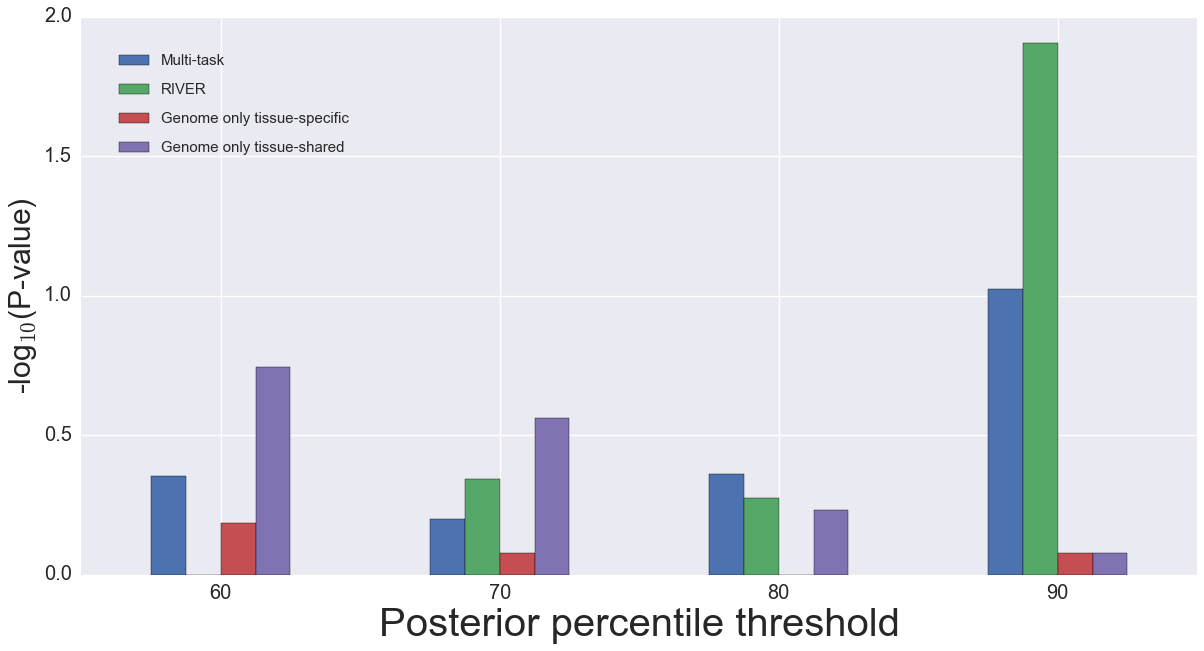

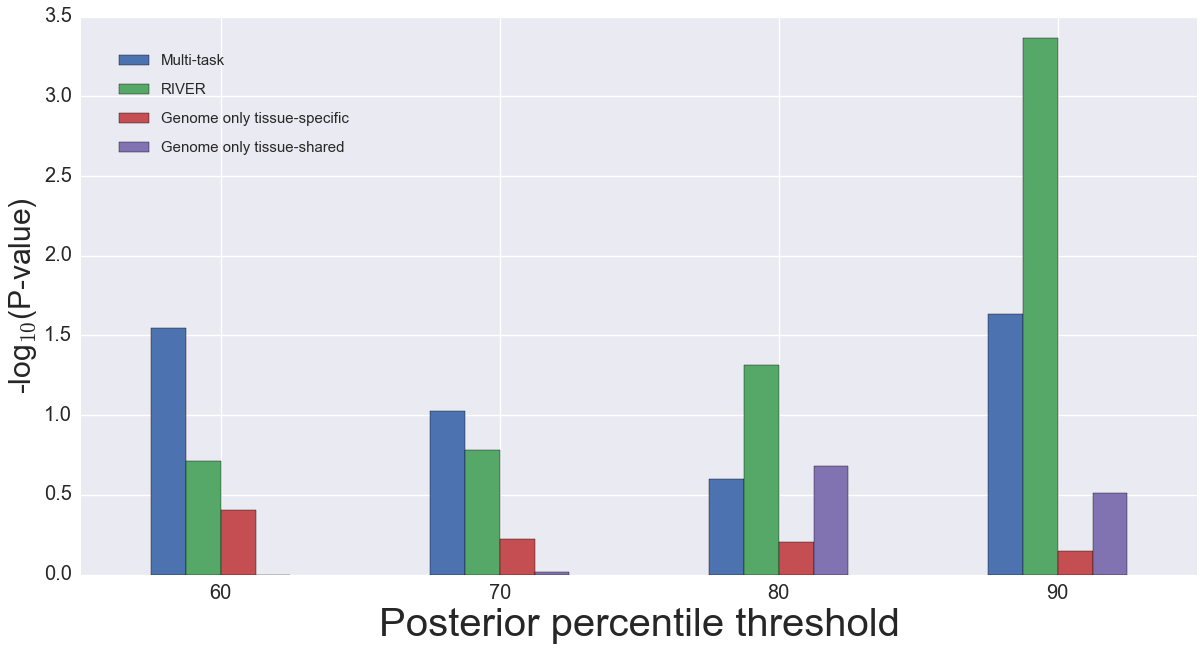

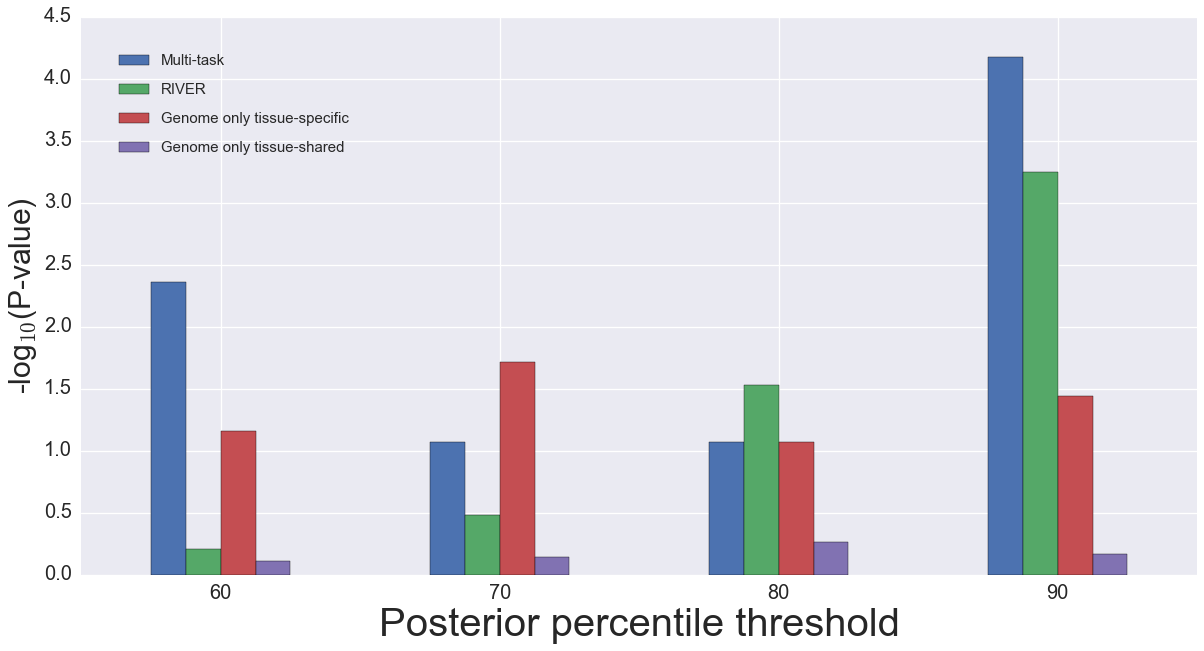

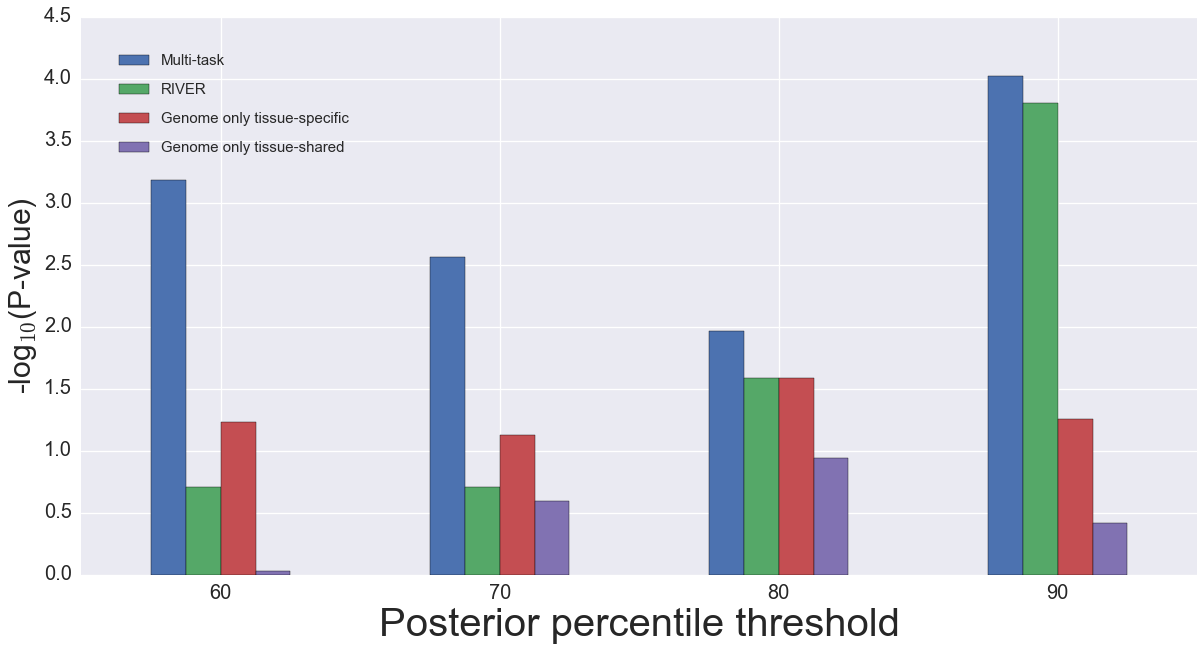

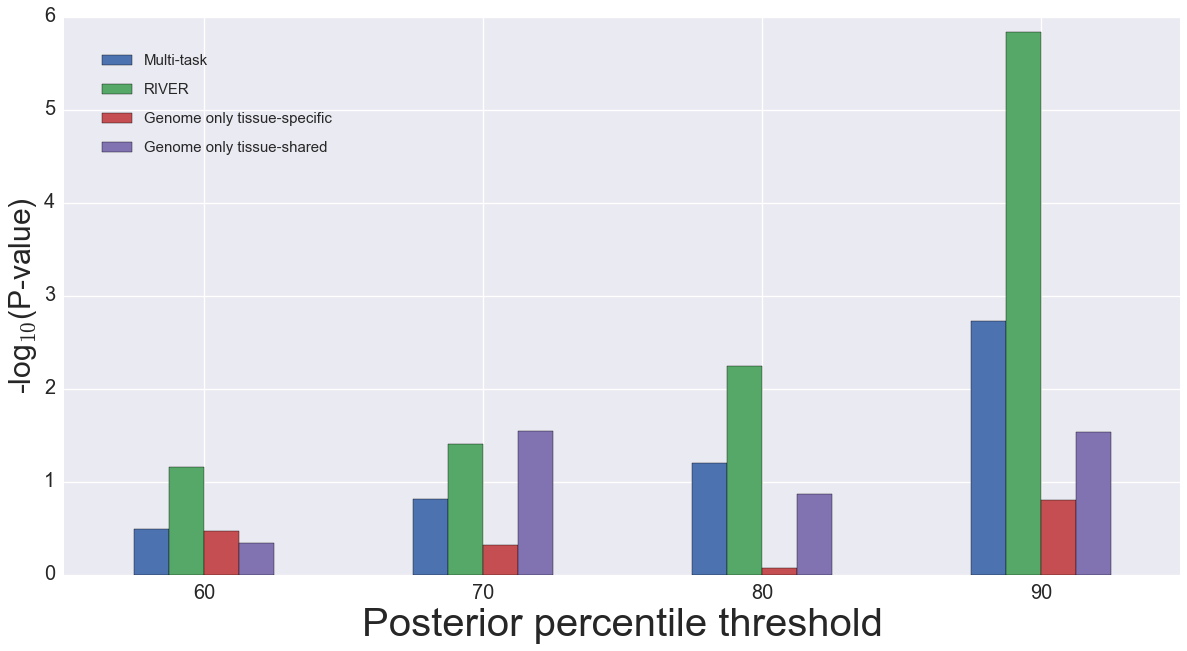

In [102]:
thresholds = [.6, .7, .8, .9]
%matplotlib inline
list(tissue_groups.keys())
for i,train in enumerate(trains):
    tissue = list(tissue_groups.keys())[i]
    #if i <= 20: continue
    results_list = []
    for thresh in thresholds:
        pvalues = []
        for model in models:
            shared_combined_mod = train
            shared_med_90_quant = shared_combined_mod['median_ase'].quantile(.90)
            shared_post_90_quant = shared_combined_mod[model].quantile(thresh)

            r = shared_combined_mod[shared_combined_mod['median_ase'] > shared_med_90_quant]
            
            top_left = r[r[model] > shared_post_90_quant].count()[-1]
            r = shared_combined_mod[shared_combined_mod['median_ase'] <= shared_med_90_quant]
            top_right = r[r[model] > shared_post_90_quant].count()[-1]
            r = shared_combined_mod[shared_combined_mod['median_ase'] > shared_med_90_quant]
            bottom_left = r[r[model] <= shared_post_90_quant].count()[-1]

            r = shared_combined_mod[shared_combined_mod['median_ase'] <= shared_med_90_quant]
            bottom_right = r[r[model] <= shared_post_90_quant].count()[-1]

            top = [top_left, top_right]
            bottom = [bottom_left, bottom_right]
            from scipy import stats
            oddsratio, pvalue = stats.fisher_exact([top, bottom])
            negative_log10_pvalue = -np.log10(pvalue)
            pvalues.extend([negative_log10_pvalue])
        results_list.append(pvalues)
    results = pd.DataFrame(results_list)
    results.columns = list(train.columns[0:4])
    results.index = ["60", "70", "80", "90"]
    results.index.name

    fig = plt.figure()
    plt.style.use('seaborn-talk')
    ax = results.plot(kind='bar',title=None,use_index=True, sort_columns=True, rot=360, figsize=(20,10), legend=(20,20))
    ax.set_xlabel("Posterior percentile threshold", fontsize=40)
    ax.set_ylabel("-log$_{10}$(P-value)", fontsize=30)
    ax.legend(loc = 'upper left', borderpad=2, labelspacing = 1, fontsize=15)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    #plt.savefig("../src/10.15.16.11groups.v7/"+tissue+"_ase.png")

In [78]:
results.columns = ['Multi-task','RIVER', 'Tissue-specific LR', 'Shared tissue LR']
results.index = ["60", "70", "80", "90"]
results.index.name

%matplotlib inline
plt.figure()
plt.style.use('seaborn-talk')
ax = results.plot(kind='bar', use_index=True, sort_columns=True, rot=360, figsize=(20,10), legend=(20,20))
ax.set_xlabel("Posterior percentile threshold", fontsize=30)
ax.set_ylabel("-log$_{10}$(P-value)", fontsize=30)
ax.legend(loc = 'upper left', borderpad=2, labelspacing = 1, fontsize=15)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

NameError: name 'results' is not defined